In [1]:
import importlib.util
if importlib.util.find_spec('empylib') is None:
    !pip install git+https://github.com/PanxoPanza/empylib.git


# Tutorial 2 - Espectros de referencia

Este es un tutorial para utilizar el módulo `ref_spectra` de la librería `empylib`

In [2]:
import empylib.ref_spectra as rf

## Distribución de Planck (`Bplanck`)
La función `Bplanck` permite determinar la radiancia espectral de un cuerpo negro.

Tal como indica la documentación, los valores de entrada son: 
- `lam` espectro de longitudes de onda en micrones
- `T` temperatura del cuerpo negro en Kelvin
- `unit` argumento opcional en caso que se necesite el espectro de radiancia en unidades de frecuencia (**no necesario para este curso**)

Como parámetro de salida, la función entregará la radiancia espectral

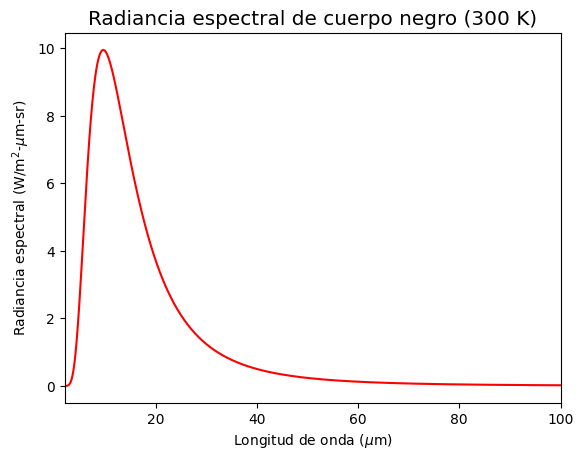

In [3]:
# -------------------------------------------------------------------
# librerías adicionales 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
# -------------------------------------------------------------------

import empylib.ref_spectra as rf

T = 300
lam = np.linspace(2.0,100,1000) # espectro de longitudes de onda (de 2 a 100 micrones)
Ibb = rf.Bplanck(lam,T)         # Temperatura del cuerpo negro

# Graficamos resultados
fig, ax = plt.subplots()
plt.rcParams['font.size'] = '12'
ax.plot(lam,Ibb,'-r')    # graficar absortancia

ax.set_xlabel('Longitud de onda ($\mu$m)')
ax.set_ylabel('Radiancia espectral (W/m$^2$-$\mu$m-sr)')
ax.set_title('Radiancia espectral de cuerpo negro (%i K)' % T)
ax.set_xlim(2,100)
plt.show()

Con esto podemos analizar la variación del poder de emisión espectral hemisférico del cuerpo negro, $\pi I_{\mathrm{bb},\lambda}$, en función de la temperatura

/home/panxopanza/miniconda3/lib/python3.9/site-packages/empylib/ref_spectra/ref_spectra.py:161: RuntimeWarning: overflow encountered in exp
  Ibb = 2*h*c0**2./ll**5*1/(np.exp(h*c0/(ll*T*kB)) - 1)*1E-6


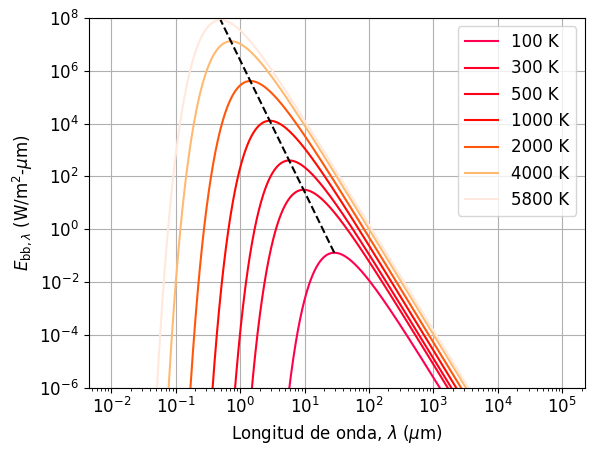

In [4]:
from empylib.ref_spectra import color_system as cs
cs = cs.hdtv

fig.set_size_inches(14, 5)
plt.rcParams['font.size'] = '12'

lam = np.logspace(-2,5,1000)       # espectro de longitudes de onda
T_list = np.array([100,300,500,    # lista de temperaturas
                   1000,2000,4000,
                   5800])

# creamos dos listas vacías para guardar el valor máximo de cada curva y la longitud de onda asociada
peak   = []            
lam_at = []

# iteramos respecto a la temperatura
for T in T_list:
    Ebb = np.pi*rf.Bplanck(lam, T)                         # poder de emisión hemisférico espectral del cuerpo negro
    html_rgb = cs.spec_to_rgb(Ebb, lam, out_fmt='html')    # color asociado a la curva
    plt.plot(lam,Ebb,label=('%i K' % T), color=html_rgb)   # graficamos el espectro usando el color anterior 
    peak.append(np.max(Ebb))                               # guardamos el máximo de la curva
    lam_at.append(lam[np.argmax(Ebb)])                     # guardamos la longitud de onda asociada al máximo

plt.plot(lam_at,peak,'--k') # graficamos la línea correspondiente a la ley de desplazamiento de Wien
plt.yscale('log')
plt.ylim(1E-6,1E8)
plt.xscale('log')
plt.grid()
plt.xlabel('Longitud de onda, $\lambda$ ($\mu$m)')
plt.ylabel('$E_{\mathrm{bb},\lambda}$ (W/m$^2$-$\mu$m)')
plt.legend()
plt.show()

Además podemos comprobar la ley de Stefan-Boltzmann para el poder de emisión hemisférico total:

\begin{equation*}
\int_\mathrm{hemi}\int_0^\infty I_{\mathrm{bb},\lambda}(\lambda,T)~\cos\theta~d\lambda~d\Omega = \pi\int_0^\infty I_{\mathrm{bb},\lambda}(\lambda,T)~d\lambda = \sigma T^4
\end{equation*}

Para la integración ocupamos la regla del trapecio a travéz de la función `numpy.trapz` (también disponible en la librería `scipy.integrate` como `trapezoid` o `trapz`). [Más info acá](https://panxopanza.github.io/metodos_numericos_mec301/7-Integracion/7-Integracion.html#regla-del-trapecio-scipy-integrate-trapezoid)

In [5]:
T = 300
lam = np.linspace(2.0,100,100) # espectro de longitudes de onda (de 2 a 100 micrones)
Ibb = rf.Bplanck(lam,T)         # Temperatura del cuerpo negro

sigma = 5.6704E-8 # constante de Stefan-Boltzmann

E_int = np.pi*np.trapz(Ibb,lam) # poder de emisión integrando la distribución de Planck
E_sb = sigma*T**4               # poder de emisión por Steffan-Boltzmann

print('Poder de emisión de cuerpo negro (integral de dist. de Planck): %.3f W/m^2' % E_int)
print('Poder de emisión de cuerpo negro (Stefan-Boltzmann): %.3f W/m^2' % E_sb)

Poder de emisión de cuerpo negro (integral de dist. de Planck): 457.136 W/m^2
Poder de emisión de cuerpo negro (Stefan-Boltzmann): 459.302 W/m^2


> Notar que los valores no son exáctamente iguales. Esto porque $\lambda$ en la integración está acotado a $\lambda\in[2,100]$ $\mu$m. El valor mejora si aumentamos el espectro de integración. Por ejemplo, para $\lambda\in[2,10000]$ $\mu$m, el poder de emisión calculado a travéz de la interal es `459.300 W/m^2`.

## Irradiación solar, espectro AM1.5 (`AM15`)

La función `AM15` entrega el espectro global y directo del AM1.5 para un arreglo de longitudes de onda.

Como valor de entrada la función requiere el espectro de longitudes de onda `lam` en unidades de micrometros. La componente del espectro (horizonal global o normal directa) se puede controlar mediante un segúndo argumento `spectra_type`, con:

- `spectra_type='global'`para componente horizontal global (GHI) del espectro solar. Su flujo total, integrado en el espectro de longitudes de onda, es $1000~\mathrm{W/m^2}$.

- `spectra_type='direct'` para componente normal directa (DNI) del espectro solar. Su flujo total, integrado en el espectro de longitudes de onda, es $900~\mathrm{W/m^2}$.

Por defecto `spectra_type='global'`

En el siguiente código graficaremos el espectro AM1.5 directo y global comparándolo con la radiación solar extraterrestre, $I_\mathrm{sun,out}$. Para este último, consideraremos la radiación de cuerpo negro mediante `Bplanck` escalada a partir de la constante solar.

\begin{equation*}
I_\mathrm{sun,out} = \frac{G_\mathrm{sun}}{\sigma T^4_\mathrm{sun}} \pi I_{\mathrm{bb},\lambda}(\lambda,T_\mathrm{sun})
\end{equation*}

donde $T_\mathrm{sun} = 5777$ K y $G_\mathrm{sun} = 1367$ W/m$^2$.

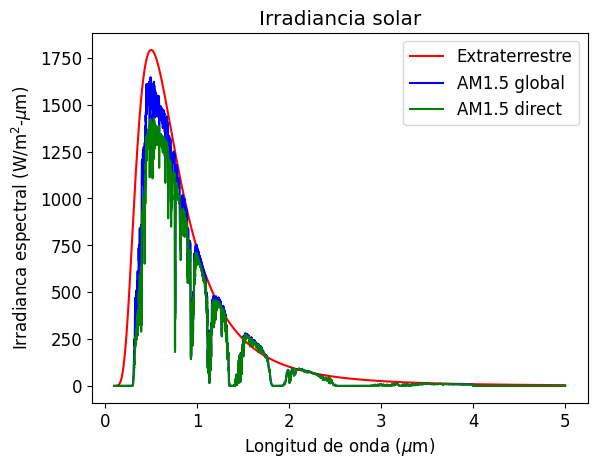

In [12]:
lam = np.linspace(0.1,5.0,10000)

sigma = 5.6704E-8 # constante de Stefan-Boltzmann
Tsun = 5777     # temperatura efectiva del sol (K)
Gsun = 1367      # constante solar (W/m^2)

Gsun_global = rf.AM15(lam,spectra_type='global')
Gsun_direct = rf.AM15(lam,spectra_type='direct')
Gsun_out    = Gsun/(sigma*Tsun**4)*np.pi*rf.Bplanck(lam,Tsun)

# Graficamos resultados
fig, ax = plt.subplots()
plt.rcParams['font.size'] = '12'
ax.plot(lam,Gsun_out   ,'-r',label ='Extraterrestre')
ax.plot(lam,Gsun_global,'-b',label ='AM1.5 global')
ax.plot(lam,Gsun_direct,'-g',label ='AM1.5 direct')

ax.set_xlabel('Longitud de onda ($\mu$m)')
ax.set_ylabel('Irradianca espectral (W/m$^2$-$\mu$m)')
ax.set_title('Irradiancia solar')
ax.legend()
plt.show()

Comprobamos el valor integrado de cada espectro

In [19]:
print('Flujo de energía, componente horizontal global:\t %.1f W/m2' % np.trapz(Gsun_global,lam))
print('Flujo de energía, componente normal directa:\t %.1f W/m2' % np.trapz(Gsun_direct,lam))

Flujo de energía, componente horizontal global:	 1000.4 W/m2
Flujo de energía, componente normal directa:	 900.1 W/m2


## Transmitancia atmosférica (`T_atmosphere`)

Esta función permite determinar la transmitancia atmosférica a partir de un espectro de longitudes de onda. Como valor de entrada la función requiere el espectro de longitudes de onda `lam` en unidades de micrometros. 

En el siguiente ejemplo graficaremos la radiación de cuerpo negro con $T = 300$ K, el AM1.5 global y la transmitancia atmosférica. Debido a la diferencia de escalas, **utilizaremos el eje de la derecha para cuantificar la transmitancia atmosférica ($\tau_{\mathrm{atm},\lambda}$), y el eje de la izquierda para la radiación solar y de cuerpo negro**.

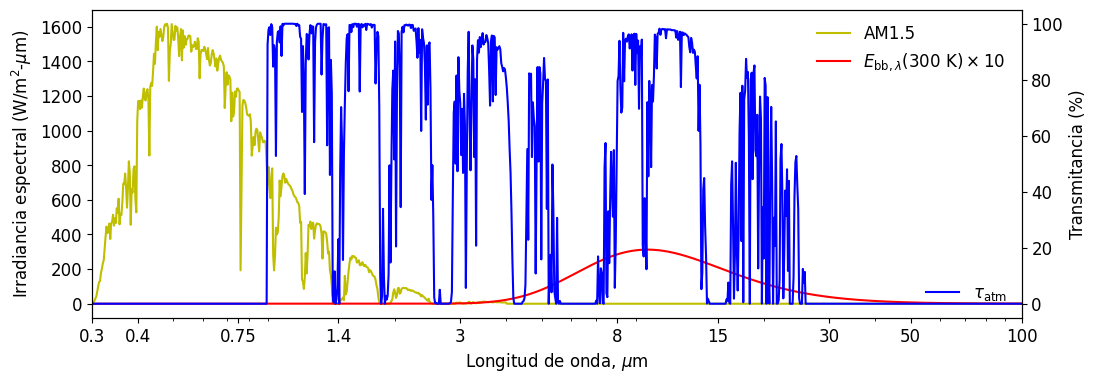

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter

lam = np.logspace(np.log10(0.3),np.log10(100),1000) # espectro de longitudes de onda
Tbb = 300                                           # temperatura de cuerpo negro

T_atm = rf.T_atmosphere(lam)     # Transmitancia atmosférica
Gsun = rf.AM15(lam)              # GHI solar AM1.5
Ebb = np.pi*rf.Bplanck(lam,Tbb)  # Poder de emisión espectral hemisférico de un cuerpo negro

fig, ax1 = plt.subplots(figsize=(12,4))
ax2=ax1.twinx()                          # segundo eje para unidades de radiación espectral
ax1.plot(lam,Gsun,'-y',label='AM1.5')
ax1.plot(lam,Ebb*10,'-r',label=r'$E_{\mathrm{bb},\lambda}(%i~\mathrm{K})\times 10$ ' % Tbb)
ax2.plot(lam,T_atm*100,'-b', label = r'$\tau_\mathrm{atm}$')

ax1.set_xlabel('Longitud de onda, $\mu$m')
ax1.set_xscale('log')
ax1.set_xticks([0.3,0.4,0.75,1.4,3,8,15,30, 50, 100])
ax1.set_ylabel('Irradiancia espectral (W/m$^2$-$\mu$m)')
ax2.set_ylabel('Transmitancia (%)')
ax2.set_xlim(0.3,100)

ax1.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.16g}'.format(y)))
ax1.legend(frameon=False,loc='upper right')
ax2.legend(frameon=False,loc='lower right')
plt.show()

**Nota** Para valores $\lambda > 20$ $\mu$m y $\lambda < 0.8$ $\mu$m, `T_atmosphere = 0` automáticamente. Aunque no es consistente con la realidad, esta condicion no induce un error significativo, ya que el espectro de emisión de la atmosféra ocurre en el infrarojo medio. Esto último, considerando a la atmósfera como un cuerpo negro a temperatura $T_\mathrm{atm}\sim 0-35$°C.

En efecto, esto lo podemos confirmar graficando la irradiancia hemisférica espectral de la atmósfera sobre una superficie horizontal:

\begin{equation*}
G_{\mathrm{atm},\lambda} = (1 - \tau_{\mathrm{atm},\lambda})\pi I_{\mathrm{bb},\lambda}(\lambda,T_\mathrm{atm})\
\end{equation*}

donde asumimos $\rho_{\mathrm{atm},\lambda} = 0$ debido a que la atmosféra esta compuesta de gases.

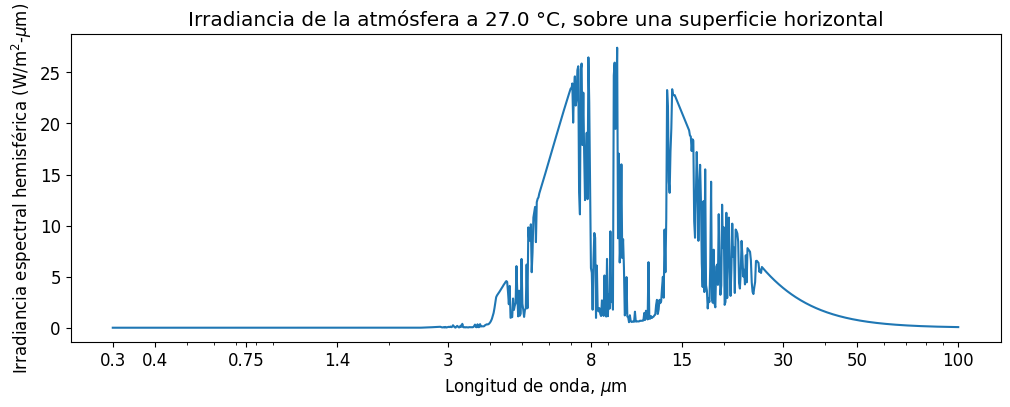

In [9]:
Tatm = 300                                           # Temperatura de la atmósfera (K)
Eatm = (1 - rf.T_atmosphere(lam))*np.pi*rf.Bplanck(lam,Tatm) # Poder de emisión de la atmósfera (W/m^2-um)

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(lam,Eatm)

ax1.set_xlabel('Longitud de onda, $\mu$m')
ax1.set_ylabel('Irradiancia espectral hemisférica (W/m$^2$-$\mu$m)')
ax1.set_title('Irradiancia de la atmósfera a %.1f °C, sobre una superficie horizontal' % (Tatm - 273))
ax1.set_xscale('log')
ax1.set_xticks([0.3,0.4,0.75,1.4,3,8,15,30, 50, 100])
ax1.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.16g}'.format(y)))